In [20]:
import pandas as pd

# 1. Carga de datos
orders = pd.read_csv('olist_orders_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')

In [21]:
# Unión de los archivos
# Esto crea el dataset principal con información del pedido y del producto, que es la parte de unión.
df = pd.merge(orders, items, on='order_id', how='inner')
df = pd.merge(df, products[['product_id', 'product_category_name']], on='product_id', how='left')

In [22]:
print(f"Dimensiones tras la unión: {df.shape}")

Dimensiones tras la unión: (112650, 15)


In [23]:
#GESTIÓN DE FECHAS (Para convertir a formato fecha en vez de texto)
date_cols = ['order_purchase_timestamp', 'order_approved_at', 
             'order_delivered_carrier_date', 'order_delivered_customer_date', 
             'order_estimated_delivery_date']

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

In [24]:
#TRATAMIENTO DE NULOS
# Calculamos cuántos nulos hay por columna
print(df.isnull().sum())

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_category_name            1603
dtype: int64


In [25]:
# Eliminamos filas donde no hay fecha de entrega (pedidos no completados)
df = df.dropna(subset=['order_delivered_customer_date'])

In [26]:
#CONTROL DE DUPLICADOS
#A veces se puede cargar una misma dos veces por error, asi que comprobamos si hay duplicados para eliminarlos.
df = df.drop_duplicates()

In [27]:
#CREACIÓN DE NUEVAS COLUMNAS, QUE APORTEN MÁS VALOR AL ANALISIS
# 1. Tiempo de entrega real (en días)
df['days_to_delivery'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# 2. Diferencia entre entrega estimada y real (Delay)
# Si es positivo, llegó tarde. Si es negativo, llegó antes de lo previsto.
df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days

# 3. Valor total del pedido (Precio + Transporte)
df['total_value'] = df['price'] + df['freight_value']

# 4. Extracción de periodos para el análisis temporal.
df['year_month'] = df['order_purchase_timestamp'].dt.to_period('M')
df['day_of_week'] = df['order_purchase_timestamp'].dt.day_name()
# 5. Clasificación del ticket
def segmentar_ticket(precio):
    if precio < 50: return 'Bajo'
    elif precio < 150: return 'Medio'
    else: return 'Alto'

df['ticket_segment'] = df['price'].apply(segmentar_ticket)
#Estado de entrega
# 0 = A tiempo o antes, 1 = Retrasado
df['is_late'] = (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']).astype(int)

In [28]:
# Verificamos una última vez la forma del dataset
print(f"Dataset listo: {df.shape[0]} filas y {df.shape[1]} columnas.")

Dataset listo: 110196 filas y 22 columnas.


In [29]:
#Guardar en CSV
df.to_csv('olist_limpio_final.csv', index=False, encoding='utf-8-sig')

In [30]:
#ANALISIS DESCRIPTIVO DE LOS DATOS
# Estadísticas descriptivas de las variables numéricas clave
variables_interes = ['price', 'freight_value', 'total_value', 'days_to_delivery', 'delivery_delay']
resumen_stats = df[variables_interes].describe()
print("--- Resumen Estadístico ---")
print(resumen_stats.round(2))

--- Resumen Estadístico ---
           price  freight_value  total_value  days_to_delivery  delivery_delay
count  110196.00      110196.00    110196.00         110196.00       110196.00
mean      119.98          19.95       139.92             12.01          -12.03
std       182.30          15.70       189.32              9.45           10.16
min         0.85           0.00         6.08              0.00         -147.00
25%        39.90          13.08        55.18              6.00          -17.00
50%        74.90          16.26        92.12             10.00          -13.00
75%       134.17          21.15       157.46             15.00           -7.00
max      6735.00         409.68      6929.31            209.00          188.00


In [31]:
#ANALISIS DE TENDENCIA CENTRAL Y DISPERSIÓN ESPECIFICO EN EL PRECIO
print(f"Media del precio: {df['price'].mean():.2f}")
print(f"Mediana del precio: {df['price'].median():.2f}")
print(f"Desviación Estándar del precio: {df['price'].std():.2f}")

# Coeficiente de Variación (CV) para ver qué tan dispersos están los datos
cv_precio = (df['price'].std() / df['price'].mean()) * 100
print(f"Coeficiente de Variación del Precio: {cv_precio:.2f}%")

Media del precio: 119.98
Mediana del precio: 74.90
Desviación Estándar del precio: 182.30
Coeficiente de Variación del Precio: 151.95%


In [32]:
#ANALISIS DESCRIPTIVO POR CATEGORÍAS 
# Ventas y transporte promedio por segmento de ticket
analisis_segmento = df.groupby('ticket_segment')[['price', 'freight_value']].agg(['mean', 'count', 'sum'])
print(analisis_segmento)

# Análisis de puntualidad: ¿Cuántos pedidos llegaron tarde?
puntualidad_resumen = df['is_late'].value_counts(normalize=True) * 100
print("\n--- Porcentaje de Pedidos ---")
print(f"A tiempo: {puntualidad_resumen[0]:.2f}%")
print(f"Con retraso: {puntualidad_resumen[1]:.2f}%")

                     price                    freight_value                  
                      mean  count         sum          mean  count        sum
ticket_segment                                                               
Alto            335.263207  22110  7412669.50     30.190322  22110  667508.03
Bajo             31.323644  38246  1198004.10     14.745999  38246  563975.48
Medio            92.500432  49840  4610221.51     19.397367  49840  966764.79

--- Porcentaje de Pedidos ---
A tiempo: 92.09%
Con retraso: 7.91%


In [33]:
#ANALISIS DE DISTRIBUCIÓN (Frecuencias)
# Conteo de pedidos por día de la semana
pedidos_por_dia = df['day_of_week'].value_counts()
print("\nPedidos por día de la semana:")
print(pedidos_por_dia)


Pedidos por día de la semana:
day_of_week
Monday       17975
Tuesday      17857
Wednesday    17217
Thursday     16433
Friday       15698
Sunday       13130
Saturday     11886
Name: count, dtype: int64


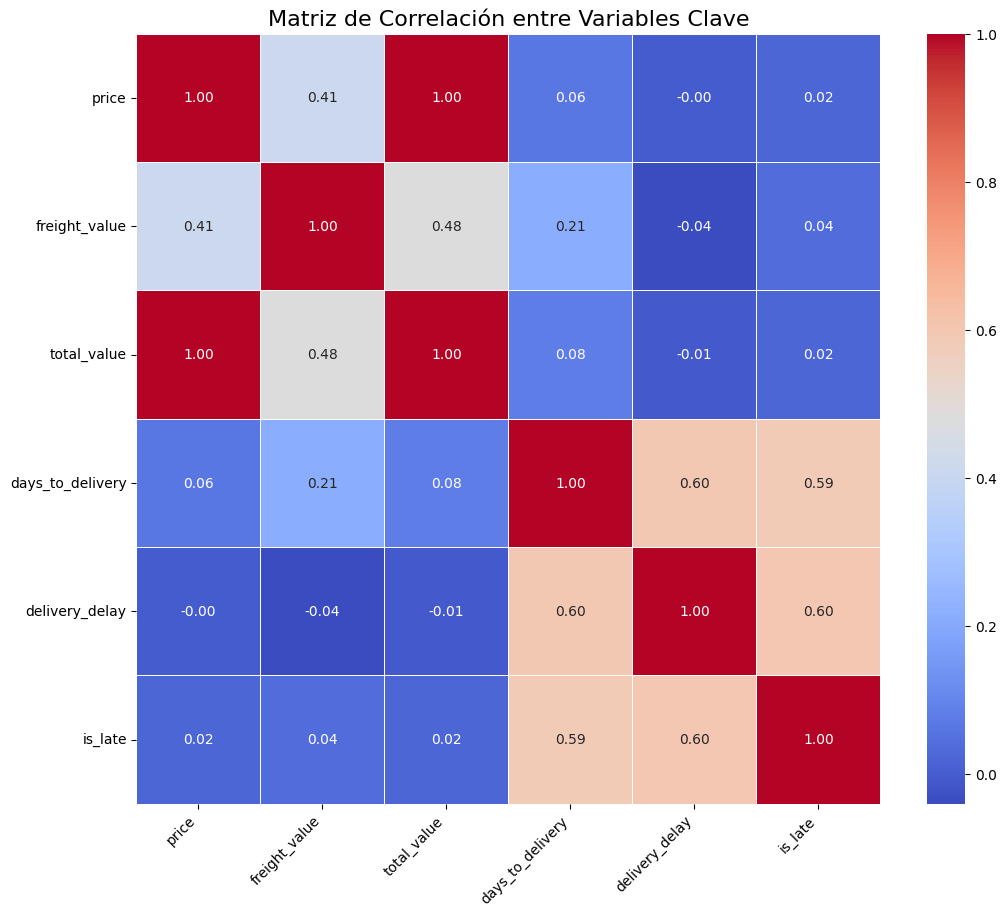

In [34]:
#ANALISIS ESTADISTICO DE LOS DATOS
#Análisis de Correlación (Mapa de Calor)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

# Seleccionamos las columnas numéricas relevantes para la correlación
# Usamos df.select_dtypes para asegurar que solo incluimos tipos numéricos
columnas_numericas_corr = df.select_dtypes(include=[np.number]).columns.tolist()

# Filtramos para asegurarnos de que solo incluimos las que realmente queremos analizar
variables_corr = ['price', 'freight_value', 'total_value', 'days_to_delivery', 
                  'delivery_delay', 'is_late', 'price_zscore', 'freight_ratio']

# Nos aseguramos de que solo existen en df
variables_corr = [col for col in variables_corr if col in df.columns]


plt.figure(figsize=(12, 10))
sns.heatmap(df[variables_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación entre Variables Clave', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

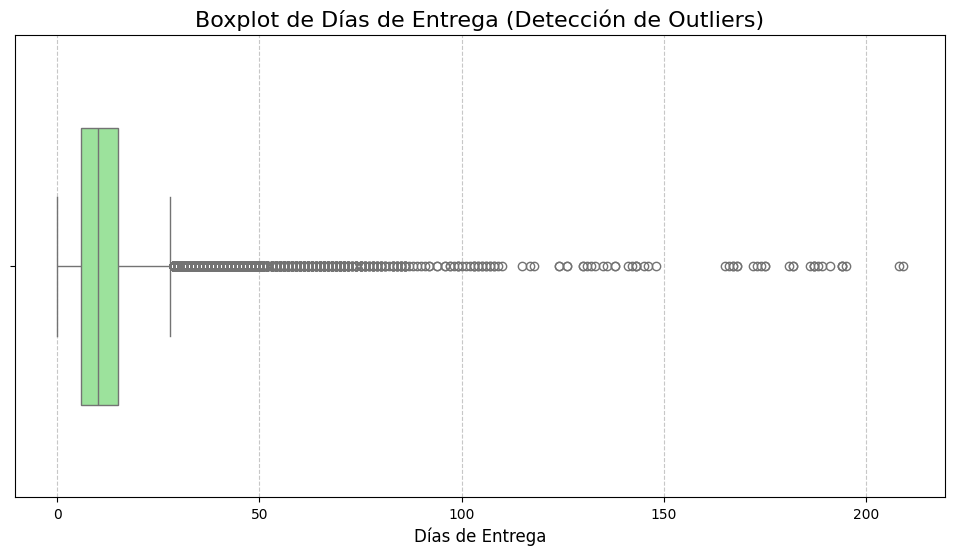

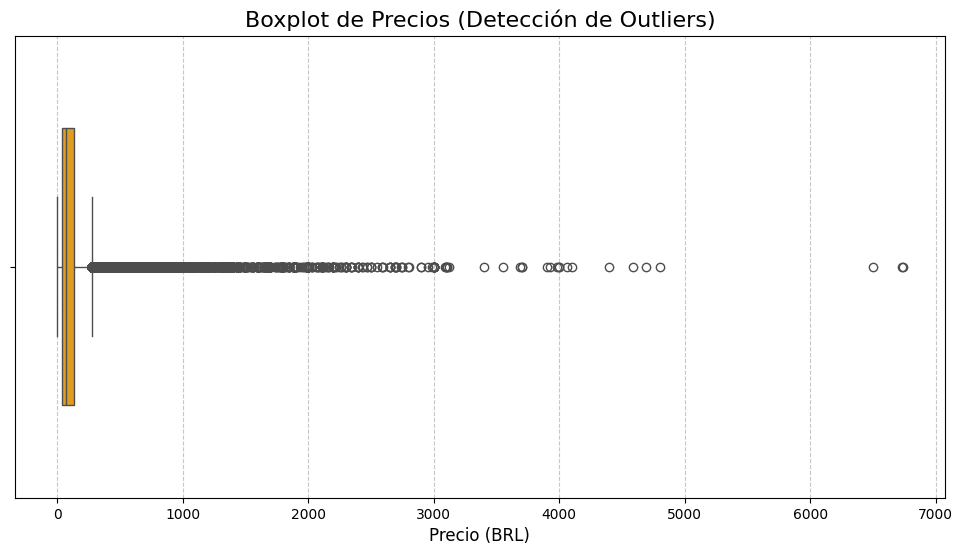

In [35]:
#Detección de Outliers (Boxplot)
#Para ver la dispersion y los valores atipicos
#Días de entrega
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['days_to_delivery'], color='lightgreen', width=0.6)
plt.title('Boxplot de Días de Entrega (Detección de Outliers)', fontsize=16)
plt.xlabel('Días de Entrega', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# precio
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['price'], color='orange', width=0.6)
plt.title('Boxplot de Precios (Detección de Outliers)', fontsize=16)
plt.xlabel('Precio (BRL)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

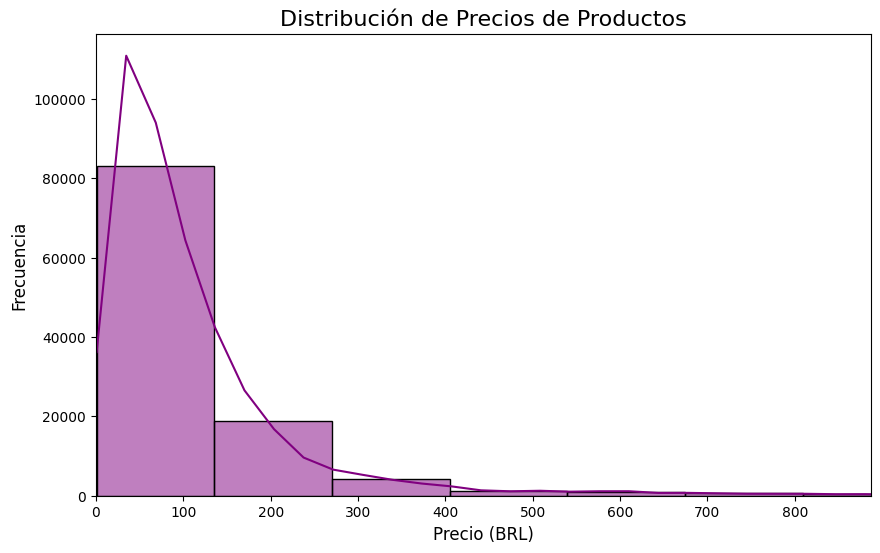

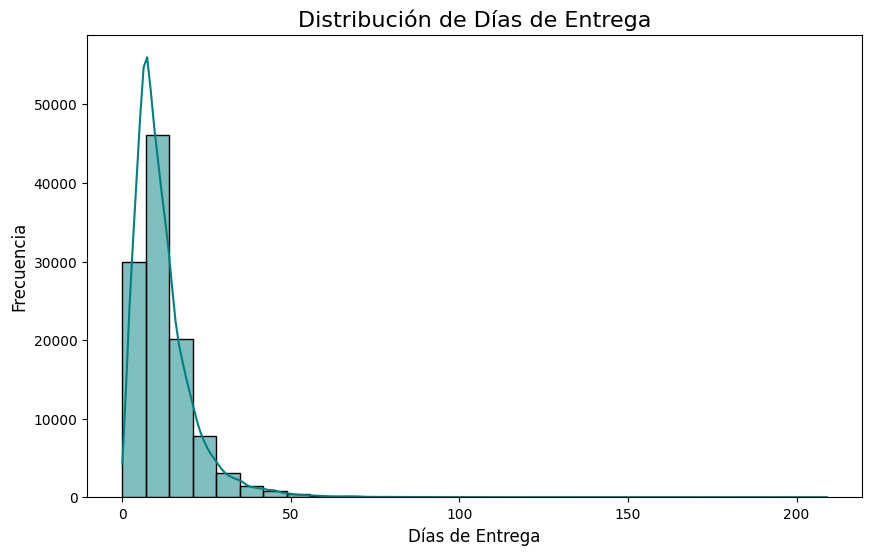

In [36]:
#Distribución de Variables Clave
#Para entender como se distribuyen los datos.
# Histograma del precio
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True, color='purple')
plt.title('Distribución de Precios de Productos', fontsize=16)
plt.xlabel('Precio (BRL)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xlim(0, df['price'].quantile(0.99)) # Limitar el eje x para mejor visualización
plt.show()

# Histograma de los días de entrega
plt.figure(figsize=(10, 6))
sns.histplot(df['days_to_delivery'].dropna(), bins=30, kde=True, color='teal')
plt.title('Distribución de Días de Entrega', fontsize=16)
plt.xlabel('Días de Entrega', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

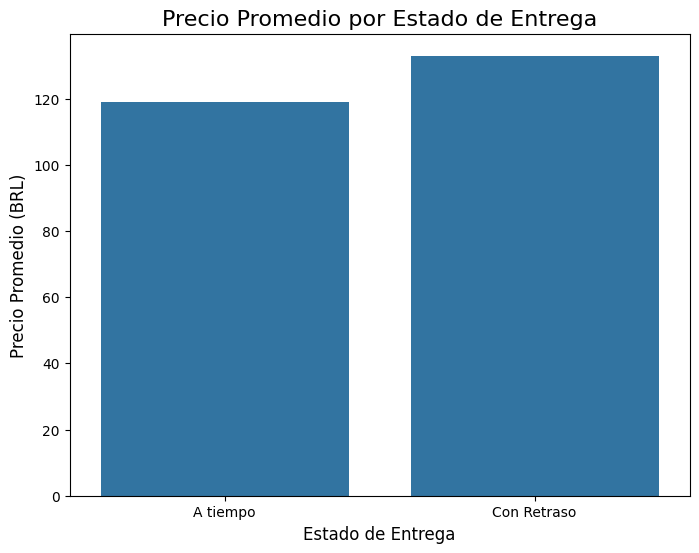

In [37]:
#Comparación de medias
#Para ver la diferencia entre el precio promedio entre los pedidos a tiempo y los con retraso.
avg_price_by_delivery = df.groupby('is_late')['price'].mean().reset_index()
avg_price_by_delivery['is_late'] = avg_price_by_delivery['is_late'].map({0: 'A tiempo', 1: 'Con Retraso'})

plt.figure(figsize=(8, 6))
sns.barplot(x='is_late', y='price', data=avg_price_by_delivery,)
plt.title('Precio Promedio por Estado de Entrega', fontsize=16)
plt.xlabel('Estado de Entrega', fontsize=12)
plt.ylabel('Precio Promedio (BRL)', fontsize=12)
plt.show()

In [ ]:
#Agregue esto al final ya que el excel no me detectaba bien las cantidades y me daban cantidades astronomicas en los totales
df.to_csv('olist_limpio_final.csv', index=False, decimal=',', encoding='utf-8-sig')